### Style Transfer

The Gatys Style Transfer

* From [this very paper](https://arxiv.org/abs/1508.06576)
* Though GAN is better for the task recently, but this style transfer is a good exercise

In [7]:
from torchvision.models.vgg import vgg16
import torch

In [3]:
vgg_model = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/paperspace/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:20<00:00, 26500698.59it/s]


Replacing all the maxpool to avgpool, drop less info, much more visually pleasing

In [12]:
for layer_i in range(len(vgg_model.features)): 
    if type(vgg_model.features[layer_i])==torch.nn.modules.pooling.MaxPool2d:
        vgg_model.features[layer_i] = torch.nn.modules.AvgPool2d(kernel_size=2,stride=2,padding=0,ceil_mode=False)

In [13]:
CUDA = torch.cuda.is_available()

In [14]:
from forgebox.ftorch import FG
fg = FG("style_transfer")
p = fg.p

==========hyper params==========
{'height': 120, 'width': 160, 'seqlen_origin': 200, 'epochs_origin': 5, 'epochs_ctt': 12, 'seqlen_ctt': 1000}


### Check The Model Structure

In [15]:
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

### Establish Learnable Image

In [16]:
from torch import nn
import torch

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [17]:
p("height",120)
p("width",160)

160

In [18]:
if CUDA:
    device = torch.device('cuda')
    def get_img():return nn.Parameter(data = torch.rand(1,p("height"),p("width"),3, requires_grad=True, device=device)).float()
else:
    def get_img():return nn.Parameter(data = torch.rand(1,p("height"),p("width"),3),)
img = get_img()

In [19]:
if CUDA:
    def param_2_npimg(img):
        img_np = img.cpu().data.numpy()
        return np.clip(np.squeeze(img_np,axis=0),0.,1.)
else:
    def param_2_npimg(img):
        img_np = img.data.numpy()
        return np.clip(np.squeeze(img_np,axis=0),0.,1.)

def show_img(img):
    return plt.imshow(param_2_npimg(img))

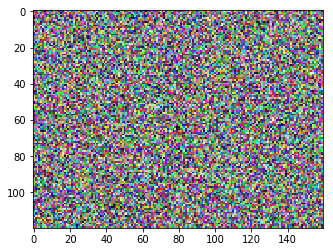

In [20]:
show_img(img)

#### Check Target Image

In [21]:
from PIL import Image

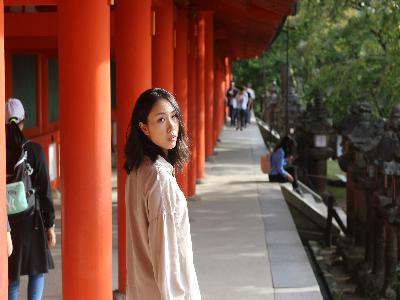

In [22]:
target = Image.open("target.jpg")

target

In [23]:
target_arr = torch.FloatTensor(np.expand_dims(np.array(target.resize((p("width"),p("height")))),axis=0))/255
if CUDA: target_arr = target_arr.cuda()
target_arr.requires_grad = False
print(target_arr.size())

torch.Size([1, 120, 160, 3])


In [24]:
target_arr

tensor([[[[ 0.8784,  0.3961,  0.2314],
          [ 0.6667,  0.2000,  0.0824],
          [ 0.5882,  0.0941,  0.0392],
          ...,
          [ 0.5765,  0.6078,  0.4549],
          [ 0.3843,  0.4431,  0.2824],
          [ 0.3216,  0.3961,  0.2196]],

         [[ 0.8902,  0.3608,  0.1843],
          [ 0.7255,  0.2431,  0.1137],
          [ 0.5490,  0.1137,  0.0392],
          ...,
          [ 0.4902,  0.5176,  0.3529],
          [ 0.3922,  0.4392,  0.2980],
          [ 0.3216,  0.3804,  0.2510]],

         [[ 0.9059,  0.3490,  0.2000],
          [ 0.7412,  0.2941,  0.1882],
          [ 0.3176,  0.0392,  0.0000],
          ...,
          [ 0.4549,  0.4824,  0.2824],
          [ 0.5020,  0.5373,  0.4157],
          [ 0.4157,  0.4510,  0.3843]],

         ...,

         [[ 1.0000,  0.6941,  0.5882],
          [ 0.9804,  0.7176,  0.6431],
          [ 1.0000,  0.6863,  0.5529],
          ...,
          [ 0.2627,  0.2510,  0.2314],
          [ 0.1176,  0.1137,  0.0941],
          [ 0.0902,  0

#### Optimizer

In [25]:
from torch.optim import Adam

In [26]:
opt = Adam([img],)

#### Learning The Image

Empty dataset

In [27]:
from torch.utils.data.dataset import Dataset
class empty(Dataset):
    def __init__(self,length):
        self.length = length
        self.seq = np.random.rand(length,2)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        return self.seq[idx]

In [28]:
from forgebox.ftorch.train import Trainer

In [29]:
trainer = Trainer(empty(p("seqlen_origin",200)),batch_size=1,shuffle=False, print_on=2)

In [30]:
loss_func = nn.MSELoss()

In [91]:
def tv_func(y):
    """
    total variation loss function
    return the total variation of an image
    measures how much a pixel varies to its neighbour
    """
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:]))+torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [31]:
@trainer.step_train
def action(*args,**kwargs):
    opt.zero_grad()
    loss = loss_func(img,target_arr)
    loss.backward()
    opt.step()
    return {"loss":loss.item()}

In [32]:
img = get_img()

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

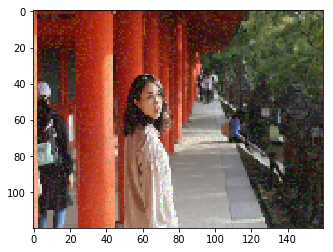

In [33]:
opt = Adam([img],)
trainer.train(p("epochs_origin",5))
show_img(img)

### Content Reconstruction

##### reconstruction from conv2_1

In [92]:
conv2blocks = vgg_model.features[:8]
if CUDA:
    conv2blocks = conv2blocks.cuda()
conv2blocks

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [93]:
def torch_shape(img):
    """
    Swap the dimensions for python is bs,h,w,c, but the image we opened is bs,c,h,w
    """
    return img.permute(0,3,1,2)

In [99]:
opt = Adam([img],)
trainer = Trainer(empty(p("seqlen_ctt",1000)),batch_size=1,shuffle=False, print_on=2)
@trainer.step_train
def action(*args,**kwargs):
    opt.zero_grad()
#     img = img.detach()
    rep1 = conv2blocks(torch_shape(img))
    rep2 = conv2blocks(torch_shape(target_arr)).detach()
    
    ctt_loss = loss_func(rep1,rep2)*p("ctt_wgt",1e-2) # content loss
    tv_loss = tv_func(torch_shape(img))*p("tv_wgt",1e-6) # total variation loss
    loss = ctt_loss+tv_loss
    
    loss.backward()
    opt.step()
        
    return {"loss":loss.item()}

In [100]:
img = get_img()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

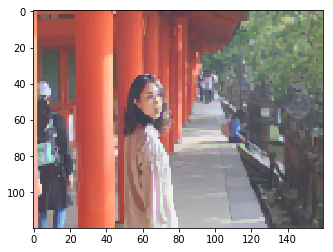

In [101]:
opt = Adam([img],)
trainer.train(p("epochs_ctt",5))
show_img(img)

##### reconstruction from conv5_1

In [104]:
conv2blocks = vgg_model.features[:25]
if CUDA:
    conv2blocks = conv2blocks.cuda()
conv2blocks

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

In [105]:
img = get_img()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

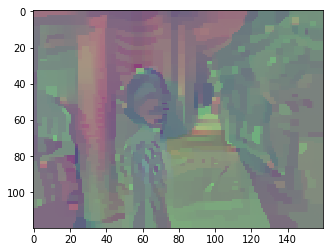

In [106]:
opt = Adam([img],)
trainer.train(p("epochs_ctt",5))
show_img(img)

#### Style Reconstruction